In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [12]:
threshold = 1

# Check if predicted value is threshold amount above or below actual value
def is_in_threshold(actual, pred):
    return pred <= actual + threshold and pred >= actual - threshold

def create_tf_column(results):
    return results.apply(lambda x: is_in_threshold(x['y_test'], x['predictions']), axis=1)

def get_score(y_test, y_pred, **kwargs):
    dataframe = pd.DataFrame(y_test, columns=['y_test'])
    dataframe['predictions'] = y_pred
    return create_tf_column(dataframe).value_counts().get(True) / dataframe.shape[0]

In [13]:
random_state=1

In [14]:
# Import data and preprocess
df = pd.read_csv("../test_data/patch_antenna/Patch Antenna S11 Data.csv")
df = df.drop(df[df['dB(S(1,1)) []'] > 0].index) # Remove all rows with positive s11

# # Split into x and y
# input_x = df.drop(columns=['dB(S(1,1)) []'], axis=1)
# input_y = df[['dB(S(1,1)) []']]

# Split data into training and testing
train_df = df.sample(frac=0.8, random_state=0)
test_df = df.drop(train_df.index)
X_train = train_df.copy()
X_test = test_df.copy()
y_train = X_train.pop('dB(S(1,1)) []')
y_test = X_test.pop('dB(S(1,1)) []')

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)) # Initialize scaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
import keras_tuner
class AntennaModel(keras_tuner.HyperModel):
    def __init__(self, input_shape):
        self.input_shape= input_shape
        
    def build(self, hp):
        model= keras.Sequential()

        for i in range(hp.Int('num_layers', 1, 4)):
            model.add(keras.layers.Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), activation='relu', input_shape=self.input_shape))
        model.add(keras.layers.Dense(1)) # Output layer

        # Tune the learning rate for the optimizer 
        hp_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=0.1)

        model.compile(loss='mse',
                    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    metrics= ['mse']
                     )

        return model

In [19]:
import keras_tuner
antenna_model = AntennaModel(input_shape=[len(X_train.keys())])
tuner = keras_tuner.RandomSearch(
    antenna_model,
    objective='val_mse',
    max_trials=3,
    executions_per_trial=1)

tuner.search_space_summary()
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train_scaled, y_train, epochs=100, validation_split=0.2, validation_data = (X_test_scaled, y_test), callbacks=[stop_early])

Trial 3 Complete [00h 00m 49s]
val_mse: 2.2353532314300537

Best val_mse So Far: 2.202643871307373
Total elapsed time: 00h 06m 09s


In [20]:
history = tuner.oracle.get_best_trials(num_trials=1)[0]

In [21]:
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

In [22]:
print('units_1:', best_hps.get('units_1'))
print('learning rate:', best_hps.get('learning_rate'))
print('best model name:', best_model.metrics_names)
print('mse:', best_model.evaluate(X_test_scaled, y_test))

units_1: 160
learning rate: 0.04279843141651064
best model name: []
256/256 [==============================] - 1s 4ms/step - loss: 2.2026 - mse: 2.2026
mse: [2.202643871307373, 2.202643871307373]


In [23]:
best_model.save("dnn.h5")

/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
# best_model = tf.keras.models.load_model("dnn.h5")

In [33]:
%%time
test_predictions = best_model.predict(X_test_scaled)

256/256 [==============================] - 1s 5ms/step
CPU times: user 1.04 s, sys: 63.9 ms, total: 1.1 s
Wall time: 2.79 s


In [26]:
%%time
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=False)
dnn_model = tuner.hypermodel.build(best_hps)
history_tuned= dnn_model.fit(X_train_scaled, y_train, 
          epochs = 500, 
          validation_data = (X_test_scaled, y_test),
          verbose=1,
          callbacks= early_stopping_cb)

Epoch 1/500
1023/1023 [==============================] - 8s 6ms/step - loss: 9.3465 - mse: 9.3465 - val_loss: 4.9216 - val_mse: 4.9216
Epoch 2/500
1023/1023 [==============================] - 6s 6ms/step - loss: 3.8706 - mse: 3.8706 - val_loss: 2.7184 - val_mse: 2.7184
Epoch 3/500
1023/1023 [==============================] - 6s 6ms/step - loss: 3.5500 - mse: 3.5500 - val_loss: 2.4073 - val_mse: 2.4073
Epoch 4/500
1023/1023 [==============================] - 6s 6ms/step - loss: 3.4606 - mse: 3.4606 - val_loss: 2.4974 - val_mse: 2.4974
Epoch 5/500
1023/1023 [==============================] - 6s 5ms/step - loss: 3.3086 - mse: 3.3086 - val_loss: 2.5433 - val_mse: 2.5433
Epoch 6/500
1023/1023 [==============================] - 6s 6ms/step - loss: 3.3544 - mse: 3.3544 - val_loss: 3.6809 - val_mse: 3.6809
Epoch 7/500
1023/1023 [==============================] - 6s 5ms/step - loss: 3.2210 - mse: 3.2210 - val_loss: 3.0003 - val_mse: 3.0003
Epoch 8/500
1023/1023 [==============================] 

In [27]:
import pickle
with open("dnn.pkl", "wb") as file:
    pickle.dump(history_tuned, file)

# with open("dnn.pkl", "rb") as file:
#     history_tuned = pickle.load(file)

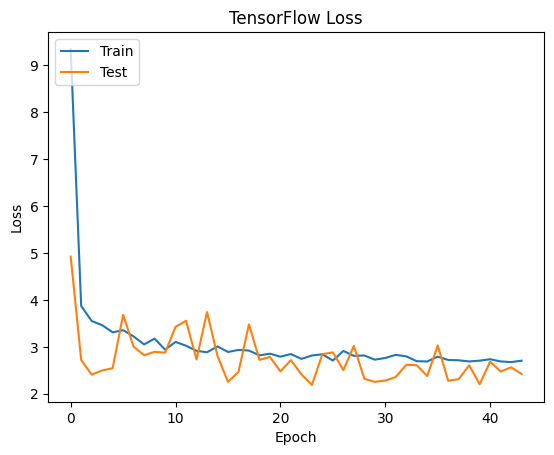

In [28]:
plt.plot(history_tuned.history['loss'])
plt.plot(history_tuned.history['val_loss'])
plt.title('TensorFlow Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [29]:
best_model.evaluate(X_test_scaled, y_test, verbose=0)

[2.202643871307373, 2.202643871307373]

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler

model = DecisionTreeRegressor(random_state=random_state) # Initialize model
scaler = MinMaxScaler(feature_range=(0,1)) # Initialize scaler
pipeline = Pipeline(steps=[('normalize', scaler), ('model', model)]) # Create pipeline with scaler and model
pipeline_fit = pipeline.fit(X_train, y_train)
sklearn_predictions = pipeline_fit.predict(X_test)

In [31]:
print(f"tensorflow score: {get_score(y_test.values.ravel(), test_predictions)}")
print(f"sklearn score: {get_score(y_test.values.ravel(), sklearn_predictions)}")

tensorflow score: 0.7756997922014424
sklearn score: 0.9118689646742452


In [40]:
scatter_plot_df = pd.DataFrame({
    's11_true': y_test.values.tolist() * 2,
    's11_prediction': np.concatenate((sklearn_predictions,test_predictions.reshape(-1))),
    's11_source': (['Sklearn'] * len(y_test.values.tolist())) + (['TensorFlow'] * len(y_test.values.tolist())),
    's11_color': (['red'] * len(y_test.values.tolist())) + (['blue'] * len(y_test.values.tolist()))
})

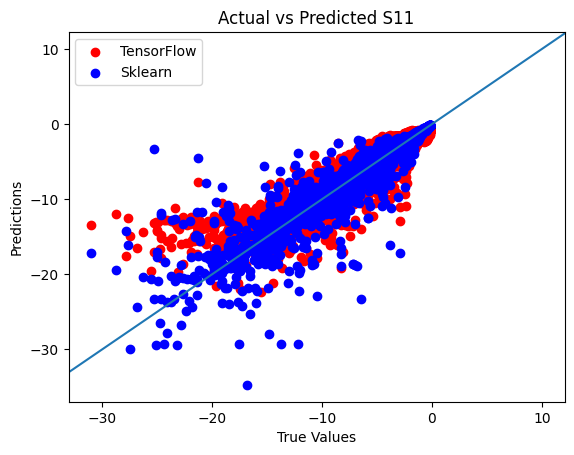

In [41]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(y_test, test_predictions, label="TensorFlow", c='r')
ax1.scatter(y_test, sklearn_predictions, label="Sklearn", c='b')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title("Actual vs Predicted S11")
plt.axline((-30,-30), (10,10))
plt.legend(loc='upper left')
plt.show()

Text(0.5, 1.0, 'Histogram of Error')

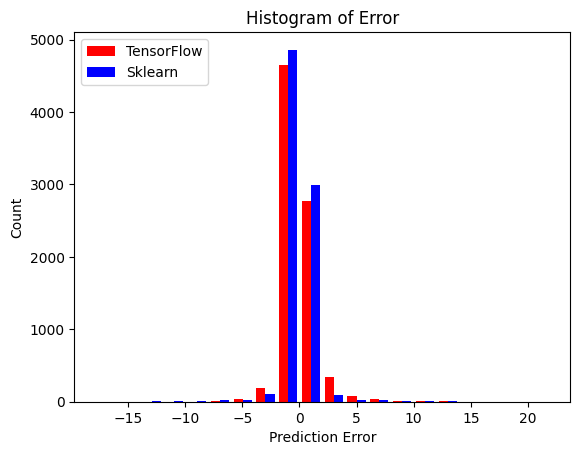

In [43]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
error_tensorflow = test_predictions.reshape(-1) - y_test
error_sklearn = sklearn_predictions - y_test
ax1.hist([error_tensorflow, error_sklearn], bins=20, color=['red', 'blue'], label=['TensorFlow', 'Sklearn'])
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.legend(loc='upper left')
plt.title("Histogram of Error")

In [45]:
analysis_df = X_test.copy()
analysis_df['dB(S(1,1)) []'] = y_test
analysis_df['tensorflow predicted s11'] = test_predictions.reshape(-1)
analysis_df['sklearn predicted s11'] = sklearn_predictions

In [46]:
analysis_df

,inset_dist [mm],L [mm],sub_thick [mm],W [mm],W0 [mm],y0 [mm],Freq [GHz],"dB(S(1,1)) []",tensorflow predicted s11,sklearn predicted s11
10,0.6,11.5,2,14.0,2.5,3.0,4.80,-0.311658,-0.902800,-0.303298
11,0.6,11.5,2,14.0,2.5,3.0,4.88,-0.332031,-0.911824,-0.323135
13,0.6,11.5,2,14.0,2.5,3.0,5.04,-0.379882,-0.929869,-0.369689
19,0.6,11.5,2,14.0,2.5,3.0,5.52,-0.610435,-0.984013,-0.592986
21,0.6,11.5,2,14.0,2.5,3.0,5.68,-0.733284,-1.002061,-0.711120
...,...,...,...,...,...,...,...,...,...,...
40870,1.4,12.5,2,15.6,3.5,5.0,9.28,-2.461545,-1.588639,-2.312953
40877,1.4,12.5,2,15.6,3.5,5.0,9.84,-5.034983,-4.732133,-5.070450
40888,1.4,12.5,2,15.6,3.5,5.0,10.72,-10.958003,-13.582414,-10.127994
40891,1.4,12.5,2,15.6,3.5,5.0,10.96,-9.207747,-15.124687,-9.059458
